In [1]:
%matplotlib nbagg

import load
import pickle
import util
import matplotlib.pyplot as plt
import numpy as np
import collections as col
import random
from sklearn.cross_validation import train_test_split


In [2]:
#review = load.shuffle_data()
#pickle.dump(review,open("processed_text.p","wb"))
#pickle.dump(labels,open("label_data.p","wb"))
X = pickle.load(open("processed_text.p", "rb" ))
#y = pickle.load(open("label_data.p","rb"))

In [3]:
train,test = train_test_split(X,test_size=0.25, random_state=42)


### Sparse Representation of Data

#### Construct Complete Dictionary excluding stop words (words appearing less than 3 times across the corpus)

In [4]:
full_dict = col.Counter()
for k in train:
    for elem in k: 
        full_dict[elem] = full_dict[elem] + 1


In [5]:
def bow_of_example(example):
    c = col.Counter()
    for elem in range(len(example) -1):
        c[example[elem]] = c[example[elem]] + 1

    return c


In [6]:
def getX(dataset):
    i = 0
    k = []
    for example in dataset:
        k.append(bow_of_example(example))
        i = i + 1
    return k

In [7]:
def getY(dataset):
    i = 0
    y = []
    for example in dataset:
        y.append(example[len(example)-1])
        i = i + 1
    return y


### Pegasos Algorithm

In [8]:
def pegasos(lamda, X_shuf,y_shuf,max_epochs):
    epoch = 0
    t = 0
    w = col.Counter()
    while epoch <= max_epochs:
        #data = list(zip(k,y))
        #random.shuffle(data)
        #X_shuf,y_shuf = zip(*data) 
        for j in range(len(X_shuf)):
            t = t+1
            eta_t = 1/(lamda*t)
            if (y_shuf[j]*util.dotProduct(w,X_shuf[j]) < 1):
                util.increment(w,-(eta_t*lamda), w)
                util.increment(w,eta_t*y_shuf[j],X_shuf[j])
            else:
                util.increment(w,-(eta_t*lamda), w)
        epoch = epoch + 1
    return w


In [9]:
def pegasos_1(lamda,X_shuf,y_shuf,max_epochs):
    epoch = 0
    t = 0
    w = col.Counter()
    while epoch <= max_epochs:
        #data = list(zip(k,y))
        #random.shuffle(data)
        #X_shuf,y_shuf = zip(*data) 
        j = 0
        for x in X_shuf:
            t = t+1
            eta_t = 1/(lamda*t)
            if (y_shuf[j]*util.dotProduct(w,x) < 1):
                util.increment(w,-(eta_t*lamda), w)
                util.increment(w,eta_t*y_shuf[j],x)
            else:
                util.increment(w,-(eta_t*lamda), w)
            j = j + 1
        epoch = epoch + 1
    return w

In [10]:
X_train = getX(train)
y_train = getY(train)
X_test = getX(test)
y_test = getY(test)

In [46]:

#%load_ext line_profiler
#%lprun -f pegasos_1 pegasos_1(0.01, w, k, y, 3)
w = pegasos(0.01,X_train,y_train,3)
pickle.dump(w,open("weight_slow.p","wb"))

2250.140427


In [11]:
def pegasos_fast(lamda, X_shuf,y_shuf,max_epochs):
    epoch = 0
    t = 1
    s = 1
    W_rep = col.Counter()
    w = col.Counter()
    util.increment(w,s,W_rep)
    while epoch <= max_epochs:
        for j in range(len(X_shuf)):
            t = t+1
            eta_t = 1/(lamda*t)
            if (y_shuf[j]*util.dotProduct(w,X_shuf[j]) < 1):
                s = (1 - (eta_t*lamda))*s
                if (s == 0):
                    s = 1
                    W_rep = col.Counter()
                    w.clear()
                    continue
                util.increment(W_rep,(1/s)*(eta_t*y_shuf[j]),X_shuf[j])
                w.clear()
                util.increment(w,s,W_rep)
        epoch = epoch + 1
        
    return w

In [40]:
#%lprun -f pegasos_fast pegasos_fast(0.01, w, k, y, 3)
w = pegasos_fast(0.01,X_train,y_train,3)
pickle.dump(w,open("weight_fast.p","wb"))

1456441941.88


### zero - one loss

In [12]:
# get the x values from test set - X
# get the y values from test set - y
# get the weight vector generated by pegasos - W
# compute the yxW. if this is greater than 0 --> pass else fail
# Compute the precent error = fail/total * 100
from __future__ import division
def zero_one_loss(w,X,y):
    result = col.Counter()
    j = 0
    for x in X_test:
        if ((y_test[j]*util.dotProduct(w,x)) > 0):
            result['correct'] = result['correct'] + 1
        else:
            result['incorrect'] = result['incorrect'] + 1
        j = j+1

    print result['correct']
    print result['incorrect']
    percent_error = result['incorrect']/(result['correct'] + result['incorrect'])
    return percent_error        


In [50]:
w = pickle.load(open("weight_slow.p","rb"))
percent_error = zero_one_loss(w,X_test,y_test)

400
100


### regularization parameter

408
92
408
92
408
92
407
93
402
98
0
500
0
500
0
500
0
500
0
500
0
500


<IPython.core.display.Javascript object>


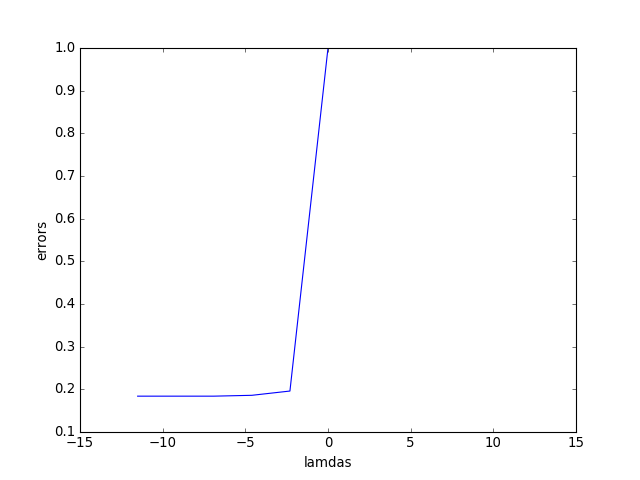

In [17]:
start = -5
stop = 6
errors = []
lamdas = []
for i in range(start,stop):
    lamda = 10 ** i
    w = pegasos_fast(lamda,X_train,y_train,3)
    errors.append(zero_one_loss(w,X_test,y_test))
    lamdas.append(lamda)
    
plt.xlabel("lamdas")
plt.ylabel("errors")
plt.plot(np.log(lamdas),errors)
plt.show()

    

